### Import Required Packages and Set Options

#### Import Base Libraries

In [1]:
import os
import sys
import git
import random

import numpy as np
import numba as nb
import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:.3f}'.format)

sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

#### Put the Main Package Library on the PYTHONPATH

In [3]:
git_repo = git.Repo('.', search_parent_directories=True)
git_root = git_repo.git.rev_parse('--show-toplevel')
cython_path = os.path.join(git_root, 'rankfm')

sys.path[0] = git_root
sys.path[1] = cython_path
sys.path[:2]

['/Users/ericlundquist/Repos/rankfm',
 '/Users/ericlundquist/Repos/rankfm/rankfm']

#### Re-Compile Cython Extension Module

In [4]:
!cd $git_root && python setup.py build_ext --inplace

building extensions with pre-generated C source...
running build_ext
copying build/lib.macosx-10.7-x86_64-3.7/rankfm/_rankfm.cpython-37m-darwin.so -> rankfm


#### Dynamically Re-Load all Package Modules on Execution

In [5]:
%load_ext autoreload
%autoreload 2

from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

#### Set File Path Constants

In [6]:
data_path = os.path.join(git_root, "data/instacart_2017_05_01")
print("\n".join([git_root, data_path]))

/Users/ericlundquist/Repos/rankfm
/Users/ericlundquist/Repos/rankfm/data/instacart_2017_05_01


### Prepare Example Data
* this data comes from https://www.instacart.com/datasets/grocery-shopping-2017
* Instacart open-sourced an anonymized version of their grocery store shopping data for research/kaggle purposes

#### Load Departments Data

In [7]:
departments_df = pd.read_csv(os.path.join(data_path, 'departments.csv'))
departments_df['department_id'] = departments_df['department_id'].astype(np.uint8)
departments_df.info()
departments_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null uint8
department       21 non-null object
dtypes: object(1), uint8(1)
memory usage: 269.0+ bytes


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


#### Load Aisles Data

In [8]:
aisles_df = pd.read_csv(os.path.join(data_path, 'aisles.csv'))
aisles_df['aisle_id'] = aisles_df['aisle_id'].astype(np.uint8)
aisles_df.info()
aisles_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null uint8
aisle       134 non-null object
dtypes: object(1), uint8(1)
memory usage: 1.3+ KB


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


#### Load Products Data

In [9]:
products_dtypes = {
    'product_id': np.int32, 
    'product_name': str, 
    'aisle_id': np.uint8, 
    'department_id': np.uint8
}

products_df = pd.read_csv(os.path.join(data_path, 'products.csv'), dtype=products_dtypes)
products_df.info()
products_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int32
product_name     49688 non-null object
aisle_id         49688 non-null uint8
department_id    49688 non-null uint8
dtypes: int32(1), object(1), uint8(2)
memory usage: 679.4+ KB


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


#### Load Orders Data

In [10]:
orders_dtypes = {
    'order_id': np.int32, 
    'user_id': np.int32, 
    'eval_set': str, 
    'order_number': np.uint8, 
    'order_dow': np.uint8, 
    'order_hour_of_day': np.uint8, 
    'days_since_prior': np.float32
}

orders_df = pd.read_csv(os.path.join(data_path, 'orders.csv'), dtype=orders_dtypes)
orders_df.info()
orders_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int32
user_id                   int32
eval_set                  object
order_number              uint8
order_dow                 uint8
order_hour_of_day         uint8
days_since_prior_order    float64
dtypes: float64(1), int32(2), object(1), uint8(3)
memory usage: 88.1+ MB


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,nan
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000


In [11]:
orders_df.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3421083.000,3421083.000,3421083.000,3421083.000,3421083.000,3214874.000
mean,1710542.000,102978.208,17.155,2.776,13.452,11.115
std,987581.740,59533.718,17.733,2.047,4.226,9.207
min,1.000,1.000,1.000,0.000,0.000,0.000
25%,855271.500,51394.000,5.000,1.000,10.000,4.000
50%,1710542.000,102689.000,11.000,3.000,13.000,7.000
75%,2565812.500,154385.000,23.000,5.000,16.000,15.000
max,3421083.000,206209.000,100.000,6.000,23.000,30.000


#### Load Order Products (Items within Each Order) Data

In [12]:
order_product_dtypes = {
    'order_id': np.int32, 
    'product_id': np.int32, 
    'add_to_cart_order': np.uint8,
    'reordered': np.uint8
}

order_products_df = pd.read_csv(os.path.join(data_path, 'order_products__prior.csv'), dtype=order_product_dtypes)
order_products_df.info()
order_products_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int32
product_id           int32
add_to_cart_order    uint8
reordered            uint8
dtypes: int32(2), uint8(2)
memory usage: 309.3 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
order_products_df.describe()

,order_id,product_id,add_to_cart_order,reordered
count,32434489.000,32434489.000,32434489.000,32434489.000
mean,1710748.519,25576.338,8.351,0.590
std,987300.696,14096.689,7.127,0.492
min,2.000,1.000,1.000,0.000
25%,855943.000,13530.000,3.000,0.000
50%,1711048.000,25256.000,6.000,1.000
75%,2565514.000,37935.000,11.000,1.000
max,3421083.000,49688.000,145.000,1.000


#### Create a User/Item Interaction Data Set

In [14]:
orders_cols = ['order_id', 'user_id']
order_products_cols = ['order_id', 'product_id']
interaction_cols = ['user_id', 'product_id', 'order_id']

interactions = pd.merge(orders_df[orders_cols], order_products_df[order_products_cols], on='order_id', how='inner')
interactions = interactions[interaction_cols]

interactions.info()
interactions.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 3 columns):
user_id       int32
product_id    int32
order_id      int32
dtypes: int32(3)
memory usage: 618.6 MB


,user_id,product_id,order_id
0,1,196,2539329
1,1,14084,2539329
2,1,12427,2539329
3,1,26088,2539329
4,1,26405,2539329


#### Create an Item Features Data Set

In [15]:
item_features = pd.get_dummies(products_df[['product_id', 'aisle_id']], columns=['aisle_id'])
item_features.head()

,product_id,aisle_id_1,aisle_id_2,aisle_id_3,aisle_id_4,aisle_id_5,aisle_id_6,aisle_id_7,aisle_id_8,aisle_id_9,...,aisle_id_125,aisle_id_126,aisle_id_127,aisle_id_128,aisle_id_129,aisle_id_130,aisle_id_131,aisle_id_132,aisle_id_133,aisle_id_134
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Do Some Basic EDA

#### Cardinality

In [16]:
n_departments = departments_df.department_id.nunique()
n_aisles = aisles_df.aisle_id.nunique()

n_users = interactions.user_id.nunique()
n_items = interactions.product_id.nunique()
n_orders = interactions.order_id.nunique()
n_interactions = len(interactions)

In [17]:
template = "departments: {}\naisles: {}\nusers: {}\nitems: {}\norders: {}\ninteractions: {}"
print(template.format(n_departments, n_aisles, n_users, n_items, n_orders, n_interactions))

departments: 21
aisles: 134
users: 206209
items: 49677
orders: 3214874
interactions: 32434489


#### Key User/Item Distributions

In [18]:
# number of items/orders by user
cnt_item_user = interactions.groupby('user_id')['product_id'].nunique()
cnt_order_user = interactions.groupby('user_id')['order_id'].nunique()

# number of users/orders by item
cnt_user_item = interactions.groupby('product_id')['user_id'].nunique()
cnt_order_item = interactions.groupby('product_id')['order_id'].nunique()

In [19]:
cnt_item_user.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count   206209.000
mean        64.536
std         56.592
min          1.000
5%           8.000
10%         13.000
25%         25.000
50%         48.000
75%         86.000
90%        139.000
95%        179.000
max        726.000
Name: product_id, dtype: float64

In [20]:
cnt_order_user.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count   206209.000
mean        15.590
std         16.655
min          3.000
5%           3.000
10%          3.000
25%          5.000
50%          9.000
75%         19.000
90%         37.000
95%         51.000
max         99.000
Name: order_id, dtype: float64

In [21]:
cnt_user_item.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count   49677.000
mean      267.890
std      1308.789
min         1.000
5%          4.000
10%         5.000
25%        11.000
50%        35.000
75%       137.000
90%       491.000
95%      1026.200
max     73956.000
Name: user_id, dtype: float64

In [22]:
cnt_order_item.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])

count    49677.000
mean       652.908
std       4792.114
min          1.000
5%           5.000
10%          7.000
25%         17.000
50%         60.000
75%        260.000
90%       1021.000
95%       2286.000
max     472565.000
Name: order_id, dtype: float64

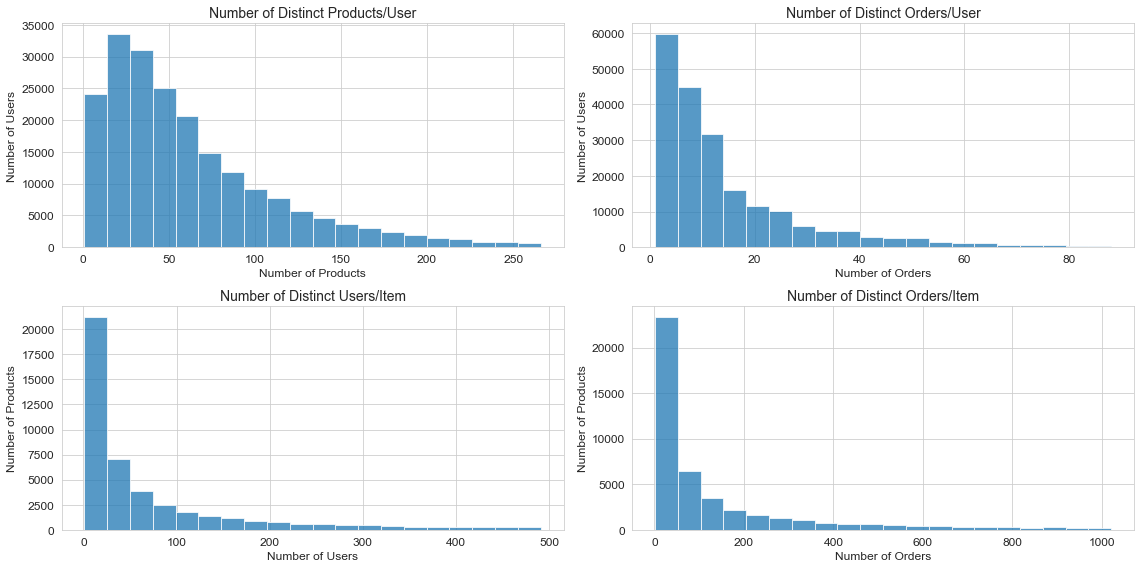

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

range_0 = [1, cnt_item_user.quantile(0.99)]
range_1 = [1, cnt_order_user.quantile(0.99)]
range_2 = [1, cnt_user_item.quantile(0.90)]
range_3 = [1, cnt_order_item.quantile(0.90)]

sns_dist_params = dict(bins=20, hist=True, kde=False, rug=False)
sns.distplot(cnt_item_user,  **sns_dist_params, hist_kws={'range': range_0, 'alpha': 0.75}, ax=axes[0])
sns.distplot(cnt_order_user, **sns_dist_params, hist_kws={'range': range_1, 'alpha': 0.75}, ax=axes[1])
sns.distplot(cnt_user_item,  **sns_dist_params, hist_kws={'range': range_2, 'alpha': 0.75}, ax=axes[2])
sns.distplot(cnt_order_item, **sns_dist_params, hist_kws={'range': range_3, 'alpha': 0.75}, ax=axes[3])

axes[0].set(title="Number of Distinct Products/User", xlabel='Number of Products', ylabel='Number of Users')
axes[1].set(title="Number of Distinct Orders/User", xlabel='Number of Orders', ylabel='Number of Users')
axes[2].set(title="Number of Distinct Users/Item", xlabel='Number of Users', ylabel='Number of Products')
axes[3].set(title="Number of Distinct Orders/Item", xlabel='Number of Orders', ylabel='Number of Products')

fig.tight_layout()
plt.show()

#### User/Item Re-Purchases

In [24]:
user_item_orders = interactions.groupby(['user_id', 'product_id']).size()
user_item_orders.head()

user_id  product_id
1        196           10
         10258          9
         10326          1
         12427         10
         13032          3
dtype: int64

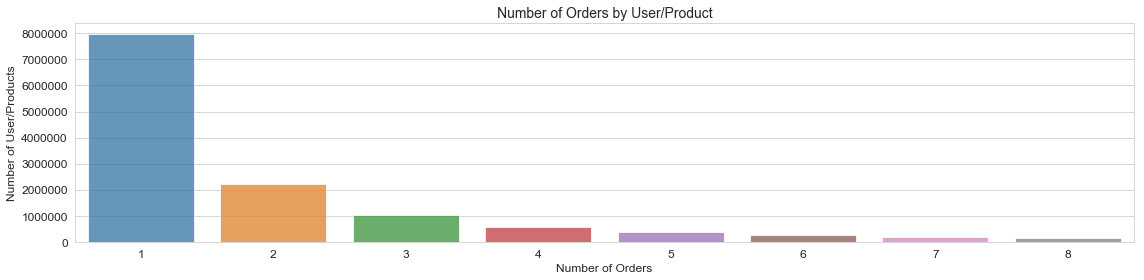

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(16, 4))
to_plot = user_item_orders[user_item_orders <= user_item_orders.quantile(0.95)]
sns.countplot(to_plot, alpha=0.75, ax=axes)
axes.set(title="Number of Orders by User/Product", xlabel='Number of Orders', ylabel='Number of User/Products')

fig.tight_layout()
plt.show()

#### Most Popular Items

In [26]:
most_popular_items = cnt_user_item.to_frame('cnt_users').reset_index().sort_values('cnt_users', ascending=False).reset_index(drop=True)
most_popular_items['pct_users'] = most_popular_items['cnt_users'] / n_users
most_popular_items = pd.merge(most_popular_items, products_df, on='product_id', how='inner')
most_popular_items = most_popular_items[['cnt_users', 'pct_users', 'product_id', 'product_name', 'aisle_id', 'department_id']]
most_popular_items.head(10)

,cnt_users,pct_users,product_id,product_name,aisle_id,department_id
0,73956,0.359,24852,Banana,24,4
1,63537,0.308,13176,Bag of Organic Bananas,24,4
2,58838,0.285,21137,Organic Strawberries,24,4
3,55037,0.267,21903,Organic Baby Spinach,123,4
4,46402,0.225,47626,Large Lemon,24,4
5,44859,0.218,26209,Limes,24,4
6,43453,0.211,47209,Organic Hass Avocado,24,4
7,43149,0.209,16797,Strawberries,24,4
8,42771,0.207,47766,Organic Avocado,24,4
9,37138,0.180,39275,Organic Blueberries,123,4


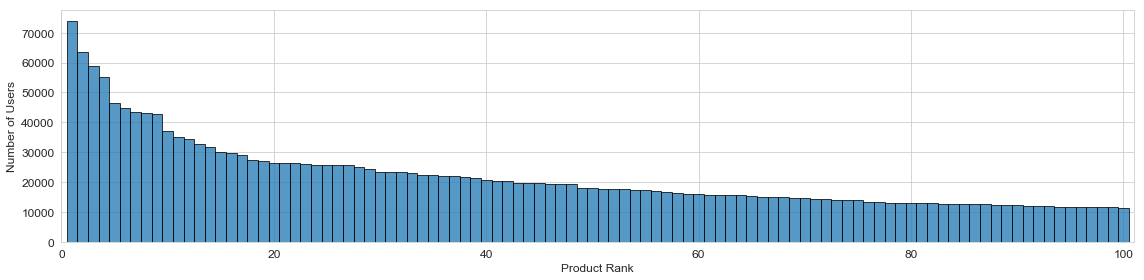

In [27]:
N = 100
to_plot = most_popular_items[:N]

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.bar(to_plot.index + 1, to_plot.cnt_users, width=1.0, linewidth=1, edgecolor='black', alpha=0.75)
ax.set(xlim=(0, N+1), xlabel='Product Rank', ylabel='Number of Users')
fig.tight_layout()
plt.show()

#### Print Matrix Shapes

In [28]:
print("users:", n_users)
print("items:", n_items)
print("interactions:", interactions.shape)
print("unique user/items pairs:", interactions[['user_id', 'product_id']].drop_duplicates().shape[0])

users: 206209
items: 49677
interactions: (32434489, 3)
unique user/items pairs: 13307953


#### Evaluate User/Item Interaction Sparsity

In [29]:
sparsity = 1 - (interactions[['user_id', 'product_id']].drop_duplicates().shape[0] / (n_users * n_items))
print("full interaction data sparsity: {}".format(round(100 * sparsity, 2)))

full interaction data sparsity: 99.87


### Subsample the Data for Initial Testing

#### Take a Random Subsample of Users

In [32]:
all_users = interactions.user_id.unique()
all_items = interactions.product_id.unique()

In [33]:
np.random.seed(1492)
s_users = np.random.choice(all_users, size=10000, replace=False)

#### Get All Interactions for Those Users

In [34]:
s_interactions = interactions[interactions.user_id.isin(s_users)].copy()
s_interactions.shape

(1615071, 3)

In [35]:
s_items = s_interactions.product_id.unique()
len(s_items)

35321

#### Re-Evaluate Cardinality/Sparsity on the Sample

In [36]:
n_s_users = len(s_users)
n_s_items = len(s_items)

print("sample users:", n_s_users)
print("sample items:", n_s_items)
print("sample interactions:", s_interactions.shape)

sample users: 10000
sample items: 35321
sample interactions: (1615071, 3)


In [37]:
s_sparsity = 1 - (s_interactions[['user_id', 'product_id']].drop_duplicates().shape[0] / (n_s_users * n_s_items))
print("sample interaction data sparsity: {}".format(round(100 * s_sparsity, 2)))

sample interaction data sparsity: 99.81


### Split the Data into Training/Validation Sets

#### Randomly Shuffle the Overall Interaction Data

In [38]:
shuffle_index = np.arange(len(s_interactions))
np.random.shuffle(shuffle_index)

s_interactions = s_interactions.iloc[shuffle_index]
s_interactions['random'] = np.random.random(size=len(s_interactions))
s_interactions.head()

,user_id,product_id,order_id,random
23537329,149525,10603,286068,0.552
9203424,58434,2078,1801316,0.730
17681539,111802,47209,1036583,0.123
10983869,69587,35221,1935694,0.915
14723363,93211,2539,1193650,0.212


#### Split Off 25% to Use for Validation

In [39]:
test_pct = 0.25
train_mask = s_interactions['random'] <  (1 - test_pct)
valid_mask = s_interactions['random'] >= (1 - test_pct)
          
interactions_total = s_interactions[['user_id', 'product_id']]
interactions_total = interactions_total.iloc[shuffle_index]

interactions_train = s_interactions[train_mask].groupby(['user_id', 'product_id']).size().to_frame('orders').reset_index()
interactions_valid = s_interactions[valid_mask].groupby(['user_id', 'product_id']).size().to_frame('orders').reset_index()

# sample_weight_train = interactions_train['orders']
# sample_weight_valid = interactions_valid['orders']
sample_weight_train = np.log2(interactions_train['orders'] + 1)
sample_weight_valid = np.log2(interactions_valid['orders'] + 1)

interactions_train = interactions_train[['user_id', 'product_id']]
interactions_valid = interactions_valid[['user_id', 'product_id']]

In [40]:
train_users = np.sort(interactions_train.user_id.unique())
valid_users = np.sort(interactions_valid.user_id.unique())
cold_start_users = set(valid_users) - set(train_users)

train_items = np.sort(interactions_train.product_id.unique())
valid_items = np.sort(interactions_valid.product_id.unique())
cold_start_items = set(valid_items) - set(train_items)

item_features_train = item_features[item_features.product_id.isin(train_items)]
item_features_valid = item_features[item_features.product_id.isin(valid_items)]

print("total shape: {}".format(interactions_total.shape))
print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))

print("\ntrain weights shape: {}".format(sample_weight_train.shape))
print("valid weights shape: {}".format(sample_weight_valid.shape))

print("\ntrain users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

print("\ntrain items: {}".format(len(train_items)))
print("valid items: {}".format(len(valid_items)))
print("number of cold-start items: {}".format(len(cold_start_items)))

print("\ntrain item features: {}".format(item_features_train.shape))
print("valid item features: {}".format(item_features_valid.shape))

total shape: (1615071, 2)
train shape: (552348, 2)
valid shape: (262425, 2)

train weights shape: (552348,)
valid weights shape: (262425,)

train users: 10000
valid users: 9936
cold-start users: set()

train items: 33362
valid items: 25320
number of cold-start items: 1959

train item features: (33362, 135)
valid item features: (25320, 135)


### Test Out Core Package Functionality

#### Initialize the Model with Chosen Hyperparameters

In [41]:
model = RankFM(factors=50, loss='warp', max_samples=50, alpha=0.01, learning_rate=0.1, learning_schedule='invscaling')

#### Fit the Model on the Training Data and Profile Computational Performance

In [42]:
%%time
model.fit(interactions_train, sample_weight=sample_weight_train, epochs=30, verbose=True)


training epoch: 0
log likelihood: -283345.625

training epoch: 1
log likelihood: -277334.03125

training epoch: 2
log likelihood: -268719.34375

training epoch: 3
log likelihood: -260925.4375

training epoch: 4
log likelihood: -252805.359375

training epoch: 5
log likelihood: -246793.5625

training epoch: 6
log likelihood: -242302.46875

training epoch: 7
log likelihood: -238361.453125

training epoch: 8
log likelihood: -235727.421875

training epoch: 9
log likelihood: -233368.15625

training epoch: 10
log likelihood: -231452.21875

training epoch: 11
log likelihood: -230046.890625

training epoch: 12
log likelihood: -228248.90625

training epoch: 13
log likelihood: -226951.71875

training epoch: 14
log likelihood: -225919.609375

training epoch: 15
log likelihood: -224618.0625

training epoch: 16
log likelihood: -224052.96875

training epoch: 17
log likelihood: -222998.890625

training epoch: 18
log likelihood: -221980.9375

training epoch: 19
log likelihood: -221699.09375

training 

#### Generate Model Scores

In [43]:
%%time
scores = model.predict(interactions_valid, cold_start='nan') 

CPU times: user 859 ms, sys: 163 ms, total: 1.02 s
Wall time: 542 ms


#### Generate TopN Recommendations

In [44]:
train_users = pd.Series(interactions_train.user_id.unique())
valid_users = pd.Series(interactions_valid.user_id.unique())
both_users = set(train_users) & set(valid_users)

len(train_users), len(valid_users), len(both_users)

(10000, 9936, 9936)

In [45]:
%%time
valid_recs = model.recommend(valid_users, n_items=10, filter_previous=False, cold_start='nan')

CPU times: user 45.3 s, sys: 166 ms, total: 45.4 s
Wall time: 45.6 s


In [46]:
print(valid_recs.shape)
valid_recs.head()

(9936, 10)


,0,1,2,3,4,5,6,7,8,9
33,33351,33129,31808,42240,33198,7969,32605,22882,24852,3856
61,24852,28842,44142,23734,16797,47626,39408,9387,23909,48205
72,21137,24852,21903,16797,39275,41950,40706,47626,13176,25890
76,49235,36107,13176,33754,19057,1006,6631,20995,33452,43961
84,47209,47766,26209,47626,24852,24964,45007,10749,4605,28842


### Evaluate Model Performance on the Validation Data

#### Specify Number of Recommended Items

In [47]:
k = 10

#### Generate Pure-Popularity Baselines

In [48]:
most_popular = interactions_train.groupby('product_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

product_id
24852    3333
13176    2904
21137    2565
21903    2511
47209    2003
47626    1983
26209    1950
47766    1841
16797    1839
39275    1590
Name: user_id, dtype: int64

In [49]:
test_user_items = interactions_valid.groupby('user_id')['product_id'].apply(set).to_dict()
test_user_items = {key: val for key, val in test_user_items.items() if key in set(train_users)}

base_hrt = np.mean([int(len(set(most_popular.index) & set(val)) > 0)                       for key, val in test_user_items.items()])
base_pre = np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()])
base_rec = np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()])

In [50]:
print("number of test users: {}".format(len(test_user_items)))
print("baseline hit rate: {:.3f}".format(base_hrt))
print("baseline precision: {:.3f}".format(base_pre))
print("baseline recall: {:.3f}".format(base_rec))

number of test users: 9936
baseline hit rate: 0.602
baseline precision: 0.134
baseline recall: 0.058


#### Generate Model Performance Validation Metrics

In [51]:
%%time
model_hrt = hit_rate(model, interactions_valid, k=k)
model_rnk = reciprocal_rank(model, interactions_valid, k=k)
model_pre = precision(model, interactions_valid, k=k)
model_rec = recall(model, interactions_valid, k=k)

CPU times: user 3min 20s, sys: 711 ms, total: 3min 21s
Wall time: 3min 21s


In [52]:
print("model hit rate: {}".format(round(model_hrt, 3)))
print("model reciprocal rank: {}".format(round(model_rnk, 3)))
print("model precision: {}".format(round(model_pre, 3)))
print("model recall: {}".format(round(model_rec, 3)))

model hit rate: 0.787
model reciprocal rank: 0.476
model precision: 0.233
model recall: 0.123


#### Assess the Diversity of Recommendations

In [53]:
model_diversity = diversity(model, interactions_valid, k=k).rename({'item_id': 'product_id'}, axis=1)
model_diversity = pd.merge(model_diversity, products_df, on='product_id', how='inner')
model_diversity = model_diversity[['cnt_users', 'pct_users', 'product_id', 'product_name', 'aisle_id', 'department_id']]
model_diversity.head(20)

,cnt_users,pct_users,product_id,product_name,aisle_id,department_id
0,5982,0.602,24852,Banana,24,4
1,5168,0.520,21137,Organic Strawberries,24,4
2,5090,0.512,13176,Bag of Organic Bananas,24,4
3,4475,0.450,21903,Organic Baby Spinach,123,4
4,3854,0.388,47209,Organic Hass Avocado,24,4
5,2661,0.268,47766,Organic Avocado,24,4
6,2620,0.264,47626,Large Lemon,24,4
7,2511,0.253,16797,Strawberries,24,4
8,2081,0.209,26209,Limes,24,4
9,1617,0.163,24964,Organic Garlic,83,4


In [76]:
coverage = np.mean(model_diversity['cnt_users'] > 0)
round(coverage, 3)

0.15

In [77]:
nonzero = model_diversity[model_diversity.cnt_users > 0]
entropy = -np.sum(nonzero['pct_users'] * np.log2(nonzero['pct_users']))
round(entropy, 2)

44.82

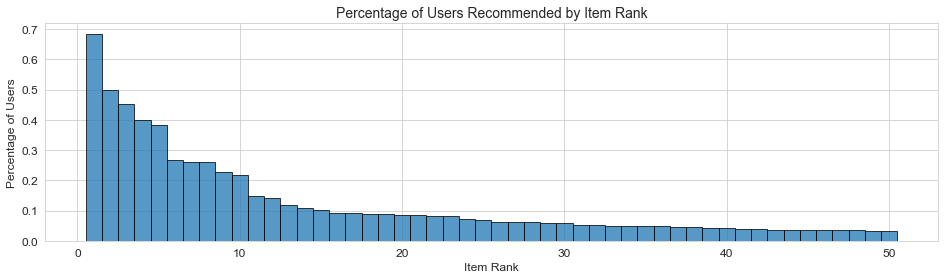

In [78]:
fig, axes = plt.subplots(1, 1, figsize=[16, 4])
N = 50

topN = model_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

#### Get Similar Items for a Few Items

In [83]:
random_user = np.random.choice(valid_users)
print("random user: {}".format(random_user))

random user: 113811


In [84]:
random_user_recs = valid_recs.loc[random_user]
random_user_recs = products_df[products_df.product_id.isin(random_user_recs)].set_index('product_id').loc[random_user_recs]
random_user_recs

,product_name,aisle_id,department_id
product_id,,,
13176,Bag of Organic Bananas,24,4
34358,Garlic,83,4
47626,Large Lemon,24,4
27966,Organic Raspberries,123,4
14999,Grade A Large Brown Eggs,86,16
24852,Banana,24,4
48370,Sensitive Toilet Paper,54,17
44142,Red Onion,83,4
26209,Limes,24,4


#### Look at Similar Products for a Few of the Random User's Recommended Products

In [85]:
most_similar_items = model.similar_items(48370)
most_similar_items = products_df.set_index('product_id').loc[most_similar_items]
most_similar_items

,product_name,aisle_id,department_id
product_id,,,
14999,Grade A Large Brown Eggs,86,16
15945,Freshly Shredded Parmesan Cheese,21,16
45698,One Ply Choose A Size Big Roll Paper Towel Rolls,54,17
4136,Living Herbs Potted Living Basil,16,4
22472,Mesquite Smoked Turkey,96,20
21144,Grab & Go Classic Hummus With Pretzel Crisps,107,19
24750,Organic Whole Fryer Chicken,35,12
38881,Shredded Iceberg Lettuce,123,4
1447,Organic Baby Lettuces,123,4


### Asess Model Performance on Novel Item Recommendations

#### Save an Array of the Most Popular Items in the Training Data

In [58]:
most_popular = interactions_train.groupby('product_id')['user_id'].count().sort_values(ascending=False)
print(len(most_popular))
most_popular.head(10)

33362


product_id
24852    3333
13176    2904
21137    2565
21903    2511
47209    2003
47626    1983
26209    1950
47766    1841
16797    1839
39275    1590
Name: user_id, dtype: int64

In [59]:
most_popular = pd.Series(most_popular.index.values)
most_popular[:10]

0    24852
1    13176
2    21137
3    21903
4    47209
5    47626
6    26209
7    47766
8    16797
9    39275
dtype: int64

#### Save the TopK Most Popular Items Not Yet Previously Purchased for Each Customer

In [60]:
train_user_items = interactions_train.groupby('user_id')['product_id'].apply(set).to_dict()
train_user_items = {key: val for key, val in test_user_items.items() if key in set(valid_users)}
most_popular_new = {user: most_popular[~most_popular.isin(train_user_items[user])][:k] for user in train_user_items.keys()}
len(most_popular_new)

9936

In [85]:
list(most_popular_new.keys())[:10]

[33, 61, 72, 76, 84, 109, 140, 146, 173, 190]

In [86]:
most_popular_new[140]

0     24852
5     47626
7     47766
8     16797
9     39275
12    45007
14    49683
15     4605
18     4920
19    42265
dtype: int64

#### Calculate the Pure-Popularity Baseline Metrics on Previously Unpurchased Items

In [87]:
base_new_hrt = np.mean([int(len(set(most_popular_new[user]) & set(test_user_items[user])) > 0)                           for user in test_user_items.keys()])
base_new_pre = np.mean([len(set(most_popular_new[user]) & set(test_user_items[user])) / len(set(most_popular_new[user])) for user in test_user_items.keys()])
base_new_rec = np.mean([len(set(most_popular_new[user]) & set(test_user_items[user])) / len(set(test_user_items[user]))  for user in test_user_items.keys()])

In [88]:
print("number of test users: {}".format(len(test_user_items)))
print("baseline new hit rate: {:.3f}".format(base_new_hrt))
print("baseline new precision: {:.3f}".format(base_new_pre))
print("baseline new recall: {:.3f}".format(base_new_rec))

number of test users: 9936
baseline new hit rate: 0.000
baseline new precision: 0.000
baseline new recall: 0.000


#### Calculate Model Performance Excluding Training Items

In [89]:
%%time
model_hrt_new = hit_rate(model, interactions_valid, k=k, filter_previous=True)
model_pre_new = precision(model, interactions_valid, k=k, filter_previous=True)
model_rec_new = recall(model, interactions_valid, k=k, filter_previous=True)

CPU times: user 7min 26s, sys: 46.7 s, total: 8min 12s
Wall time: 2min 18s


In [90]:
print("model new hit rate: {}".format(round(model_hrt_new, 3)))
print("model new precision: {}".format(round(model_pre_new, 3)))
print("model new recall: {}".format(round(model_rec_new, 3)))

model new hit rate: 0.307
model new precision: 0.039
model new recall: 0.024


### Compare **RankFM** Performance to the **LightFM** Package

In [62]:
from lightfm.data import Dataset
from lightfm import LightFM, evaluation

#### Create Required Data Structures

In [63]:
all_users = interactions_total.user_id.unique()
all_items = interactions_total.product_id.unique()
print(len(all_users), len(all_items))

lfm_dataset = Dataset()
lfm_dataset.fit(users=all_users, items=all_items)

lfm_interactions, lfm_weights = lfm_dataset.build_interactions(zip(interactions_train['user_id'], interactions_train['product_id'], sample_weight_train))
lfm_interactions, lfm_weights

10000 35321


(<10000x35321 sparse matrix of type '<class 'numpy.int32'>'
 	with 552348 stored elements in COOrdinate format>,
 <10000x35321 sparse matrix of type '<class 'numpy.float32'>'
 	with 552348 stored elements in COOrdinate format>)

#### Fit the Model

In [64]:
lfm_model = LightFM(no_components=50, loss='warp', max_sampled=50)
lfm_model

In [65]:
%%time
lfm_model.fit(lfm_interactions, epochs=20, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
CPU times: user 46.9 s, sys: 154 ms, total: 47.1 s
Wall time: 47.2 s


In [66]:
print(all_users.shape, all_items.shape)
print(valid_users.shape, valid_items.shape)

(10000,) (35321,)
(9936,) (25320,)


#### Evaluate LightFM's Performance on Hold-Out Data

In [67]:
lfm_test_interactions, lfm_test_weights = lfm_dataset.build_interactions(zip(interactions_valid['user_id'], interactions_valid['product_id']))
lfm_test_interactions

<10000x35321 sparse matrix of type '<class 'numpy.int32'>'
	with 262425 stored elements in COOrdinate format>

In [68]:
%%time
lfm_rnk = evaluation.reciprocal_rank(lfm_model, lfm_test_interactions).mean()
lfm_pre = evaluation.precision_at_k(lfm_model, lfm_test_interactions, k=k).mean()
lfm_rec = evaluation.recall_at_k(lfm_model, lfm_test_interactions, k=k).mean()

In [69]:
print("reciprocal_rank: {:.3f}".format(lfm_rnk))
print("precision: {:.3f}".format(lfm_pre))
print("recall: {:.3f}".format(lfm_rec))

reciprocal_rank: 0.406
precision: 0.176
recall: 0.092


### Compare **RankFM** Performance to the **Implicit** Package

In [38]:
from implicit.als import AlternatingLeastSquares

#### Create Required Data Structures

In [39]:
# create zero-based index position to identifier mappings
index_to_user = pd.Series(np.sort(np.unique(interactions_train['user_id'])))
index_to_item = pd.Series(np.sort(np.unique(interactions_train['product_id'])))

# create reverse mappings from identifiers to zero-based index positions
user_to_index = pd.Series(data=index_to_user.index, index=index_to_user.values)
item_to_index = pd.Series(data=index_to_item.index, index=index_to_item.values)

interactions_train_imp = interactions_train.copy()
interactions_train_imp['user_id'] = interactions_train['user_id'].map(user_to_index)
interactions_train_imp['product_id'] = interactions_train['product_id'].map(item_to_index)

n_users_train = len(index_to_user)
n_items_train = len(index_to_item)
n_inter_train = len(interactions_train_imp)
n_users_train, n_items_train, n_inter_train

(10000, 33362, 552348)

In [40]:
data = np.ones(n_inter_train)
rows = interactions_train_imp['user_id']
cols = interactions_train_imp['product_id']

user_items_imp = csr_matrix((data, (rows, cols)), shape=(n_users_train, n_items_train))
item_users_imp = user_items_imp.T.tocsr()
user_items_imp, item_users_imp

(<10000x33362 sparse matrix of type '<class 'numpy.float64'>'
 	with 552348 stored elements in Compressed Sparse Row format>,
 <33362x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 552348 stored elements in Compressed Sparse Row format>)

#### Fit the Model

In [41]:
imp_model = AlternatingLeastSquares(factors=50, use_native=True, use_cg=False)
imp_model

In [ ]:
%%time

imp_model.fit(item_users_imp, show_progress=False)

#### Generate TopN Recommendations for Each User

In [110]:
recs_imp = imp_model.recommend_all(user_items=user_items_imp, N=k)
recs_imp = pd.DataFrame(recs_imp, index=index_to_user.values).apply(lambda c: c.map(index_to_item))
recs_imp = recs_imp.loc[valid_users]
recs_imp.head()

,0,1,2,3,4,5,6,7,8,9
33,44142,49235,5077,34969,47626,28985,21616,15290,8174,19057
61,44142,29487,5077,28985,21616,39993,31553,45066,41787,9387
72,33731,2295,46667,38293,29487,41950,23734,43961,34969,14992
76,28985,27344,18531,42701,48364,9076,31553,22035,5077,33000
84,17794,34126,44632,5077,39928,8277,48679,28842,27344,21616


In [111]:
print(recs_imp.shape)
print(np.array_equal(recs_imp.index, valid_users))

(9936, 10)
True


#### Evaluate **Implicit**'s Performance on Hold-Out Data

In [112]:
valid_user_items = interactions_valid.groupby('user_id')['product_id'].apply(set).to_dict()

In [113]:
imp_hrt = np.mean([int(len(set(recs_imp.loc[u]) & valid_user_items[u]) > 0) for u in valid_users])
imp_pre = np.mean([len(set(recs_imp.loc[u]) & valid_user_items[u]) / len(recs_imp.loc[u]) for u in valid_users])
imp_rec = np.mean([len(set(recs_imp.loc[u]) & valid_user_items[u]) / len(valid_user_items[u]) for u in valid_users])

In [114]:
print("hit_rate: {:.3f}".format(imp_hrt))
print("precision: {:.3f}".format(imp_pre))
print("recall: {:.3f}".format(imp_rec))

hit_rate: 0.264
precision: 0.032
recall: 0.019
